# Regularization

## 1. Introduction

Recall from the last lab that we had a training accuracy close to 90% and a test set accuracy close to 76%.

2 questions:
- Is there a high bias? yes/no
- Is there a high variance? yes/no

Recall that "high bias" is a relative concept. Knowing we have 7 classes and the topics are related, we'll assume that a 90% accuracy is pretty good and the bias on the training set is low. In this lab, we'll use the notion of training/validation/test set to get better insights of how we can mitigate our variance, and we'll look at a few regularization techniques.

Everything in section 2 of this lab is basically what you have done in the previous lab with respect to preprocessing the data. We'll do that again here, and then we'll rerun our model but this time:
- We'll include a validation set as well, and start with using early stopping to minimize the discrepancy between train and test accuracy.
- We'll use L1 and L2 regularization.
- We'll use dropout regularization.
- We'll look at the effect of using more data.

## 2. Pre-processing the bank complaints as in the previous lab

### 2.1 Import the libraries and take a sample

In [85]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer

df = pd.read_csv('Bank_complaints.csv')
df.head()

,Product,Consumer complaint narrative
0,Student loan,In XX/XX/XXXX I filled out the Fedlaon applica...
1,Student loan,I am being contacted by a debt collector for p...
2,Student loan,I cosigned XXXX student loans at SallieMae for...
3,Student loan,Navient has sytematically and illegally failed...
4,Student loan,My wife became eligible for XXXX Loan Forgiven...


In [86]:
import random
random.seed(123)
df = df.sample(10000)
df.index = range(10000)
product = df["Product"]
complaints = df["Consumer complaint narrative"]

There are 7 types of complaints

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Product                         10000 non-null object
Consumer complaint narrative    10000 non-null object
dtypes: object(2)
memory usage: 156.3+ KB


### 2.2 One-hot encoding of the complaints

Only keep 2,000 most common words and use one-hot encoding

In [88]:
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(complaints)

In [89]:
sequences = tokenizer.texts_to_sequences(complaints)

In [90]:
one_hot_results= tokenizer.texts_to_matrix(complaints, mode='binary')
word_index = tokenizer.word_index
np.shape(one_hot_results)

(10000, 2000)

### 2.3 One-hot encoding of the products

Use LabelEncoder to encode the labels (From category names to category numbers)

In [91]:
le = preprocessing.LabelEncoder()
le.fit(product)

LabelEncoder()

In [92]:
 list(le.classes_)

['Bank account or service',
 'Checking or savings account',
 'Consumer Loan',
 'Credit card',
 'Credit reporting',
 'Mortgage',
 'Student loan']

Transform `product` into a numeric vector

In [93]:
product_cat = le.transform(product) 
product_cat

array([4, 1, 2, ..., 5, 2, 6])

Then, use onehot encoding to get to vectors with 0's and 1's.

In [94]:
product_onehot = to_categorical(product_cat)

In [95]:
product_onehot

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [96]:
np.shape(product_onehot)

(10000, 7)

### 2.4 Train - test split

In [97]:
import random
random.seed(123)
test_index = random.sample(range(1,10000), 1500)

In [98]:
test = one_hot_results[test_index]
train = np.delete(one_hot_results, test_index, 0)

In [99]:
label_test = product_onehot[test_index]
label_train = np.delete(product_onehot, test_index, 0)

In [100]:
print(np.shape(label_test))
print(np.shape(label_train))
print(np.shape(test))
print(np.shape(train))

(1500, 7)
(8500, 7)
(1500, 2000)
(8500, 2000)


## 3. Running the model using a validation set.

### 3.1 Creating the validation set

In the lecture we mentioned that in deep learning, we generally keep aside a validation set, which is used during hyperparameter tuning. Then when we have made the final model decision, the test set is used to define the final model perforance. 

In this example, let's take the first 1000 cases out of the training set to become the validation set. You should do this for both `train` and `label_train`.

In [101]:
random.seed(123)
val = train[:1000]
train_final = train[1000:]
label_val = label_train[:1000]
label_train_final = label_train[1000:]

### 3.2 Creating, compiling and running the model

Let's rebuild a fully connected (Dense) layer network with relu activations in Keras.

Recall that we used 2 hidden with 50 units in the first layer and 25 in the second, both with a `relu` activation function. Because we are dealing with a multiclass problem (classifying the complaints into 7 classes), we use a use a softmax classifyer in order to output 7 class probabilities per case.

In [102]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

We use the same settings as before to compile the model

In [103]:
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In the compiler, you'll be passing the optimizer, loss function, and metrics. Train the model for 120 epochs in mini-batches of 256 samples. This time, let's include the argument `validation_data` and assign it `(val, label_val)`

In [104]:
history = model.fit(train_final,
                    label_train_final,
                    epochs=120,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/120
7500/7500 [==============================] - 1s 90us/step - loss: 1.9229 - acc: 0.2043 - val_loss: 1.9183 - val_acc: 0.1990
Epoch 2/120
7500/7500 [==============================] - 0s 54us/step - loss: 1.8940 - acc: 0.2269 - val_loss: 1.8931 - val_acc: 0.2130
Epoch 3/120
7500/7500 [==============================] - 0s 49us/step - loss: 1.8668 - acc: 0.2431 - val_loss: 1.8655 - val_acc: 0.2270
Epoch 4/120
7500/7500 [==============================] - 0s 53us/step - loss: 1.8360 - acc: 0.2629 - val_loss: 1.8319 - val_acc: 0.2380
Epoch 5/120
7500/7500 [==============================] - 0s 66us/step - loss: 1.7991 - acc: 0.2900 - val_loss: 1.7915 - val_acc: 0.2680
Epoch 6/120
7500/7500 [==============================] - 0s 60us/step - loss: 1.7558 - acc: 0.3209 - val_loss: 1.7430 - val_acc: 0.3190
Epoch 7/120
7500/7500 [==============================] - 0s 53us/step - loss: 1.7065 - acc: 0.3632 - val_loss: 1.6905 - val_acc: 0.3510


7500/7500 [==============================] - 0s 64us/step - loss: 0.5232 - acc: 0.8217 - val_loss: 0.6583 - val_acc: 0.7350
Epoch 61/120
7500/7500 [==============================] - 0s 61us/step - loss: 0.5180 - acc: 0.8241 - val_loss: 0.6561 - val_acc: 0.7460
Epoch 62/120
7500/7500 [==============================] - 0s 65us/step - loss: 0.5136 - acc: 0.8249 - val_loss: 0.6548 - val_acc: 0.7460
Epoch 63/120
7500/7500 [==============================] - 0s 64us/step - loss: 0.5092 - acc: 0.8280 - val_loss: 0.6520 - val_acc: 0.7450
Epoch 64/120
7500/7500 [==============================] - 0s 64us/step - loss: 0.5049 - acc: 0.8303 - val_loss: 0.6522 - val_acc: 0.7370
Epoch 65/120
7500/7500 [==============================] - 0s 59us/step - loss: 0.5004 - acc: 0.8331 - val_loss: 0.6500 - val_acc: 0.7440
Epoch 66/120
7500/7500 [==============================] - 0s 58us/step - loss: 0.4962 - acc: 0.8331 - val_loss: 0.6495 - val_acc: 0.7390
Epoch 67/120
7500/7500 [==============================

Epoch 120/120
7500/7500 [==============================] - 0s 54us/step - loss: 0.3346 - acc: 0.8963 - val_loss: 0.6414 - val_acc: 0.7440


The dictionary `history` contains four entries this time: one per metric that was being monitored during training and during validation.

In [106]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

### Plotting the results

Let's plot the result similarly to what we have done in the previous lab. This time though, let's iclude the training and the validation loss in the same plot. We'll do the same thing for the training and validation accuracy.

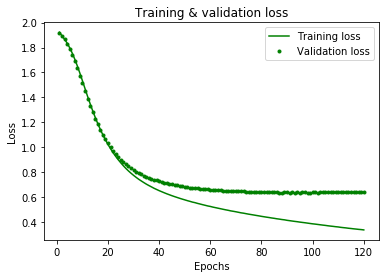

In [110]:
plt.clf()

import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'g.', label='Validation loss')

plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

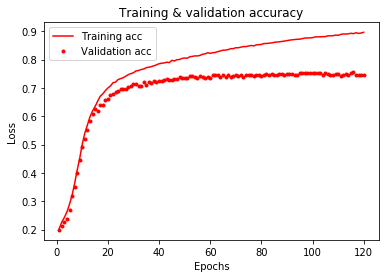

In [112]:
plt.clf()

acc_values = history_dict['acc'] 
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'r.', label='Validation acc')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We observe an interesting pattern here: although the training accuracy keeps increasing when going through more epochs, and the training loss keeps decreasing, the validation accuracy and loss seem to be reaching a status quo around the 50th epoch. This means that we're actually **overfitting** to the train data when we do as many epochs as we were doing. Luckily, you learned how to tackle overfitting in the previous lecture! For starters, it does seem clear that we are training too long. So let's stop training at the 50th epoch first (so-called "early stopping") before we move to more advanced regularization techniques!

## 3. Early stopping

In [113]:
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

final_model = model.fit(train_final,
                    label_train_final,
                    epochs=50,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/50
7500/7500 [==============================] - 1s 184us/step - loss: 1.9421 - acc: 0.1569 - val_loss: 1.9422 - val_acc: 0.1450
Epoch 2/50
7500/7500 [==============================] - 0s 57us/step - loss: 1.9232 - acc: 0.1736 - val_loss: 1.9281 - val_acc: 0.1560
Epoch 3/50
7500/7500 [==============================] - 0s 54us/step - loss: 1.9083 - acc: 0.1984 - val_loss: 1.9150 - val_acc: 0.1910
Epoch 4/50
7500/7500 [==============================] - 0s 51us/step - loss: 1.8939 - acc: 0.2221 - val_loss: 1.9017 - val_acc: 0.2110
Epoch 5/50
7500/7500 [==============================] - 0s 50us/step - loss: 1.8785 - acc: 0.2424 - val_loss: 1.8872 - val_acc: 0.2340
Epoch 6/50
7500/7500 [==============================] - 0s 46us/step - loss: 1.8615 - acc: 0.2589 - val_loss: 1.8710 - val_acc: 0.2500
Epoch 7/50
7500/7500 [==============================] - 0s 47us/step - loss: 1.8424 - acc: 0.2713 - val_loss: 1.8527 - val_acc: 0.2660
Epoch 

Now, you can use the test set to make label predictions

In [120]:
results_train = model.evaluate(train_final, label_train_final)

7500/7500 [==============================] - 0s 61us/step


In [121]:
results_test = model.evaluate(test, label_test)

1500/1500 [==============================] - 0s 78us/step


In [122]:
results_train

[0.6503562787055969, 0.7776000000317892]

In [123]:
results_test

[0.7675205413500468, 0.7166666661898295]

We've significantly reduced the variance, but now our test results are actually also worse comparing with the results we obtained before. Let's see what else we can do!

## 4. L2 regularization

In [127]:
from keras import regularizers
model = models.Sequential()
model.add(layers.Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.02), input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, kernel_regularizer=regularizers.l2(0.02), activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

final_model = model.fit(train_final,
                    label_train_final,
                    epochs=120,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/120
7500/7500 [==============================] - 2s 203us/step - loss: 4.5245 - acc: 0.1604 - val_loss: 4.4713 - val_acc: 0.1880
Epoch 2/120
7500/7500 [==============================] - 0s 49us/step - loss: 4.4357 - acc: 0.2099 - val_loss: 4.3908 - val_acc: 0.2220
Epoch 3/120
7500/7500 [==============================] - 0s 51us/step - loss: 4.3557 - acc: 0.2492 - val_loss: 4.3140 - val_acc: 0.2420
Epoch 4/120
7500/7500 [==============================] - 0s 53us/step - loss: 4.2773 - acc: 0.2712 - val_loss: 4.2373 - val_acc: 0.2620
Epoch 5/120
7500/7500 [==============================] - 0s 52us/step - loss: 4.1986 - acc: 0.2853 - val_loss: 4.1594 - val_acc: 0.2750
Epoch 6/120
7500/7500 [==============================] - 0s 48us/step - loss: 4.1191 - acc: 0.2976 - val_loss: 4.0805 - val_acc: 0.2980
Epoch 7/120
7500/7500 [==============================] - 0s 46us/step - loss: 4.0389 - acc: 0.3135 - val_loss: 3.9995 - val_acc: 0.3120

7500/7500 [==============================] - 0s 51us/step - loss: 1.5936 - acc: 0.7828 - val_loss: 1.6536 - val_acc: 0.7370
Epoch 61/120
7500/7500 [==============================] - 0s 47us/step - loss: 1.5754 - acc: 0.7873 - val_loss: 1.6361 - val_acc: 0.7380
Epoch 62/120
7500/7500 [==============================] - 0s 47us/step - loss: 1.5584 - acc: 0.7876 - val_loss: 1.6211 - val_acc: 0.7390
Epoch 63/120
7500/7500 [==============================] - 0s 44us/step - loss: 1.5415 - acc: 0.7899 - val_loss: 1.6064 - val_acc: 0.7380
Epoch 64/120
7500/7500 [==============================] - 0s 47us/step - loss: 1.5247 - acc: 0.7899 - val_loss: 1.5900 - val_acc: 0.7330
Epoch 65/120
7500/7500 [==============================] - 0s 47us/step - loss: 1.5093 - acc: 0.7928 - val_loss: 1.5761 - val_acc: 0.7340
Epoch 66/120
7500/7500 [==============================] - 0s 49us/step - loss: 1.4934 - acc: 0.7920 - val_loss: 1.5620 - val_acc: 0.7350
Epoch 67/120
7500/7500 [==============================

Epoch 120/120
7500/7500 [==============================] - 0s 45us/step - loss: 1.0219 - acc: 0.8356 - val_loss: 1.1398 - val_acc: 0.7390


# SOURCES

https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Consumer_complaints.ipynb

https://catalog.data.gov/dataset/consumer-complaint-database